In [46]:
#Create a machine learning model that can predict the genre of a movie based on its plot summary or other textual information. You can use techniques like TF-IDF or word embeddings with classifiers such as Naive Bayes, Logistic Regression, or Support Vector Machines.
# use the train_data.txt for that 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [27]:
train_df = pd.read_csv('train_data.txt', sep=':::',header=None, names=['Id', 'Title', 'Genre', 'Description'], engine='python')
train_df

,Id,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [28]:
test_df = pd.read_csv('test_data.txt', sep=':::',header=None, names=['Id', 'Title', 'Description'], engine='python')
test_df

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


In [29]:
train_df['Genre'].value_counts()

Genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

In [30]:
train_df.describe()

,Id
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


In [31]:
test_df.describe()

,Id
count,54200.000000
mean,27100.500000
std,15646.336632
min,1.000000
25%,13550.750000
50%,27100.500000
75%,40650.250000
max,54200.000000


In [32]:
train_df.isnull().sum()


Id             0
Title          0
Genre          0
Description    0
dtype: int64

In [33]:
test_df.isnull().sum()

Id             0
Title          0
Description    0
dtype: int64

<Axes: xlabel='count', ylabel='Genre'>

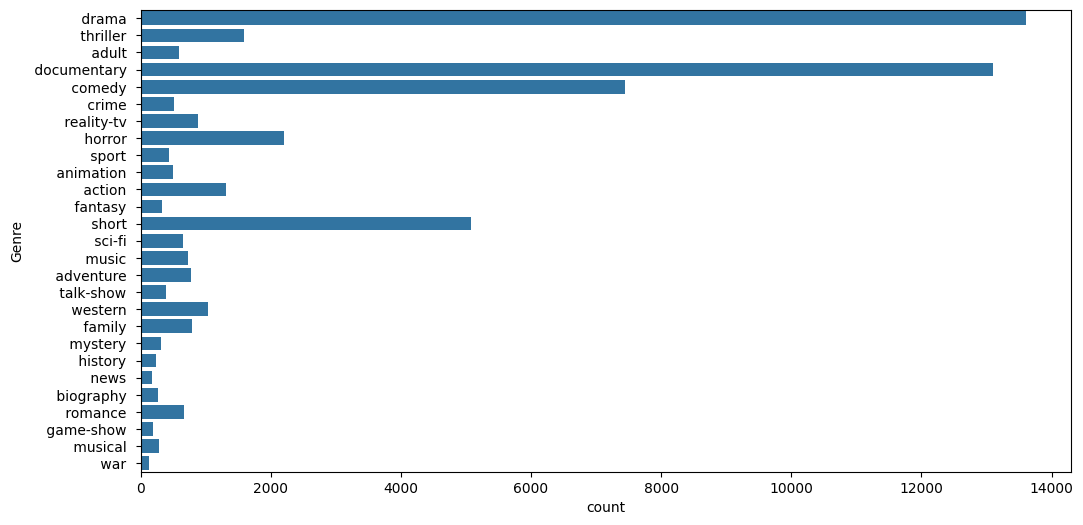

In [34]:
# Count plot for Genre
plt.figure(figsize=(12,6))
sns.countplot(train_df['Genre'])

In [35]:
# Preprocessing
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text) 
    text = text.lower() 
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'\s+', ' ', text).strip() 
    return text

train_df['Description'] = train_df['Description'].apply(preprocess_text)
test_df['Description'] = test_df['Description'].apply(preprocess_text)

In [36]:
train_df['Description']

0        listening in to a conversation between his doc...
1        a brother and sister with a past incestuous re...
2        as the bus empties the students for their fiel...
3        to help their unemployed father make ends meet...
4        the films title refers not only to the unrecov...
                               ...                        
54209    this shortlived nbc live sitcom centered on bo...
54210    the next generation of exploitation the sister...
54211    ze bestaan echt is a standup comedy about grow...
54212    walter and vivian live in the country and have...
54213    on labor day weekend the most intense hurrican...
Name: Description, Length: 54214, dtype: object

In [37]:
test_df['Description']

0        lr brane loves his life his car his apartment ...
1        spain march quico is a very naughty child of t...
2        one year in the life of albin and his family o...
3        his father has died he hasnt spoken with his b...
4        before he was known internationally as a marti...
                               ...                        
54195    covering multiple genres tales of light dark i...
54196    as alice and cora munro attempt to find their ...
54197    a movie years in the making oliver twist the a...
54198    popular but mysterious rock dj mike mallard as...
54199    curitiba is a city in movement with rhythms an...
Name: Description, Length: 54200, dtype: object

In [38]:
# Tokenization
train_df['Description'] = train_df['Description'].apply(word_tokenize)
test_df['Description'] = test_df['Description'].apply(word_tokenize)

In [39]:
# Stopwords removal
stop_words = set(stopwords.words('english'))
train_df['Description'] = train_df['Description'].apply(lambda x: [word for word in x if word not in stop_words])
test_df['Description'] = test_df['Description'].apply(lambda x: [word for word in x if word not in stop_words])

In [40]:
# Stemming
stemmer = PorterStemmer()
train_df['Description'] = train_df['Description'].apply(lambda x: [stemmer.stem(word) for word in x])
test_df['Description'] = test_df['Description'].apply(lambda x: [stemmer.stem(word) for word in x])

In [41]:
# Joining words
train_df['Description'] = train_df['Description'].apply(lambda x: ' '.join(x))
test_df['Description'] = test_df['Description'].apply(lambda x: ' '.join(x))

In [43]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X = tfidf.fit_transform(train_df['Description'])
y = train_df['Genre']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [48]:
y_pred = nb.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.5216268560361523
Confusion Matrix:
 [[  20    0    0    0    0   14    0   58  158    0    0    0    0    5
     0    0    0    0    0    0    0    1    3    0    3    0    1]
 [   0    6   10    0    0   36    0    9   48    0    0    0    0    0
     0    0    0    0    0    0    0    3    0    0    0    0    0]
 [   1    2   10    0    0   13    0   42   62    0    0    0    0    5
     0    0    0    0    0    0    1    2    0    0    0    0    1]
 [   1    0    0    0    0   16    0   36   46    0    0    0    0    0
     1    0    0    0    0    0    0    4    0    0    0    0    0]
 [   0    0    0    0    0    2    0   43   16    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   3    0    1    0    0  645    0  155  624    0    0    0    0    6
     0    0    0    0    0    0    0    9    0    0    0    0    0]
 [   2    0    0    0    0   10    0   13   76    0    0    0    0    1
     0    0    0    0    0    0    0    

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                precision    recall  f1-score   support

      action        0.62      0.08      0.14       263
       adult        0.67      0.05      0.10       112
   adventure        0.43      0.07      0.12       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.51      0.45      0.48      1443
       crime        0.00      0.00      0.00       107
 documentary        0.57      0.88      0.69      2659
       drama        0.46      0.82      0.59      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        1.00      0.03      0.05        40
     history        0.00      0.00      0.00        45
      horror        0.77      0.37      0.50       431
       music        0.76      0.13      0.22       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
# Predicting on test data
X_test = tfidf.transform(test_df['Description'])
y_pred = nb.predict(X_test)

test_df['Genre'] = y_pred
test_df

,Id,Title,Description,Genre
0,1,Edgar's Lunch (1998),lr brane love life car apart job especi girlfr...,drama
1,2,La guerra de papá (1977),spain march quico naughti child three belong w...,drama
2,3,Off the Beaten Track (2010),one year life albin famili shepherd north tran...,documentary
3,4,Meu Amigo Hindu (2015),father die hasnt spoken brother year seriou ca...,drama
4,5,Er nu zhai (1955),known intern martial art superstar bruce lee a...,drama
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",cover multipl genr tale light dark antholog we...,drama
54196,54197,Der letzte Mohikaner (1965),alic cora munro attempt find father british of...,drama
54197,54198,Oliver Twink (2007),movi year make oliv twist art dodger fagin lov...,drama
54198,54199,Slipstream (1973),popular mysteri rock dj mike mallard askew bro...,documentary


In [52]:
# Split the data according to logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
y_pred = lr.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.5840634510744259
Confusion Matrix:
 [[  71    0    1    0    0   27    1   31   87    0    0    0    0   11
     0    0    0    0    0    0    3    7    6    0   17    0    1]
 [   0   24   16    0    0   35    0    4   22    0    0    0    0    0
     0    0    0    0    0    0    0   10    0    0    0    0    1]
 [   6    1   22    1    0   15    0   23   41    1    0    0    0   11
     0    0    0    0    1    0    5    6    0    0    3    0    3]
 [   1    0    3    8    0   21    0   15   26    9    1    0    0    2
     1    0    0    0    0    0    7   10    0    0    0    0    0]
 [   0    0    0    0    0    2    0   39   18    0    0    0    0    0
     1    0    0    0    0    0    0    1    0    0    0    0    0]
 [   4    0    1    2    0  869    1   73  405    3    0    0    0   14
     2    0    0    0    7    1    1   53    2    0    4    0    1]
 [   9    0    0    0    0   17    2   10   46    0    0    0    0    6
     0    0    0    0    0    0    1    

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                precision    recall  f1-score   support

      action        0.53      0.27      0.36       263
       adult        0.83      0.21      0.34       112
   adventure        0.39      0.16      0.23       139
   animation        0.47      0.08      0.13       104
   biography        0.00      0.00      0.00        61
      comedy        0.51      0.60      0.55      1443
       crime        0.29      0.02      0.04       107
 documentary        0.68      0.84      0.75      2659
       drama        0.55      0.78      0.64      2697
      family        0.44      0.09      0.15       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.95      0.50      0.66        40
     history        0.00      0.00      0.00        45
      horror        0.63      0.57      0.60       431
       music        0.65      0.50      0.57       144
     musical        1.00      0.02      0.04        50
     mystery        0.00      0.00      

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
# Predicting on test data
X_test = tfidf.transform(test_df['Description'])
y_pred = lr.predict(X_test)

test_df['Genre'] = y_pred
test_df

,Id,Title,Description,Genre
0,1,Edgar's Lunch (1998),lr brane love life car apart job especi girlfr...,drama
1,2,La guerra de papá (1977),spain march quico naughti child three belong w...,drama
2,3,Off the Beaten Track (2010),one year life albin famili shepherd north tran...,documentary
3,4,Meu Amigo Hindu (2015),father die hasnt spoken brother year seriou ca...,drama
4,5,Er nu zhai (1955),known intern martial art superstar bruce lee a...,drama
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",cover multipl genr tale light dark antholog we...,drama
54196,54197,Der letzte Mohikaner (1965),alic cora munro attempt find father british of...,action
54197,54198,Oliver Twink (2007),movi year make oliv twist art dodger fagin lov...,comedy
54198,54199,Slipstream (1973),popular mysteri rock dj mike mallard askew bro...,drama


In [55]:
# Split the data according to SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM
svm = SVC()
svm.fit(X_train, y_train)

In [ ]:
y_pred = svm.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

In [ ]:
# Predicting on test data
X_test = tfidf.transform(test_df['Description'])
y_pred = svm.predict(X_test)

test_df['Genre'] = y_pred
test_df